# Brazilian E-Commerce Dataset by Olist

# NLP - Topic Modelling

In the following section we will look into applying topic modelling to the reviews. Topic modelling is an unsupervised algorithm used for recognition word and phrase patterns and by using that categorizing each review. As a business case for OLIST topic modelling is very interesting as a good model lets them categorize their reviews automatically, thus reducing the amount of manual work going through reviews manually. Goodwill and a proper relationship with customers is essential to sellers. Therefor, sellers often seek to respond to reviews, whether they are good or bad, to show they are committed to their customers. But for a company of the size of OLIST, depending on the topic different people should respond. This could be delivery-service, people responsible for product quality, packaging etc. <br>
The data for OLIST is in portugese, which means we are going to use a Portugese Stemmer and for final interpretation of models use Google's Translation API.

#### KPI - Key Performance Indicator

*Reducing the number of manual taskes and automating the assigning of reviews to different proccesses an order.* <br>
This KPI should reduce labour costs of employees going through and distributing reviews. For those not usually responding to reviews, this automatic distribution of relevant reviews will encourage them to respond, thus achieving a healthier relationship with the customers.

**Packages for Section**

In [99]:
import numpy as np
import pandas as pd
import sys, os
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

#Data cleaning
import string
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('wordnet')
nltk.download('rslp')
portugese_stopwords = nltk.corpus.stopwords.words('portuguese')
##Extend stopwords list to ensure extensive version (Link collapsed)
stop = pd.read_csv('https://gist.githubusercontent.com/alopes/5358189/raw/2107d809cca6b83ce3d8e04dbd9463283025284f/stopwords.txt',header=None)
portugese_stopwords.extend(stop.values.ravel())

#Gensim:
from gensim import models
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

#SciKitLearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV



#Visuals:
import wordcloud
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from folium.plugins import HeatMap
from IPython.display import Image
from IPython.core.display import HTML 



#Google Translation API
from googletrans import Translator
translator = Translator()

#Set seed
import random
random.seed(42)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


### Load dataset

The available datasets for Brazilian E-Commerce Public Dataset will be merged into the final dataset. <br>
    - olist_order_items_dataset
    - olist_order_payments_dataset
    - olist_orders_dataset
    - olist_order_reviews_dataset
    - olist_products_dataset
    - olist_customers_dataset
    - product_category_name_translation

In [100]:
orders = pd.read_csv('data/olist_orders_dataset.csv')
payments = pd.read_csv('data/olist_order_payments_dataset.csv')
items = pd.read_csv('data/olist_order_items_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
category = pd.read_csv('data/product_category_name_translation.csv')
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
customer = pd.read_csv('data/olist_customers_dataset.csv')

The files are merged by a left-join operation acording to the following data schema.



In [101]:
Image(url='https://i.imgur.com/HRhd2Y0.png',width=600)

In [102]:
#Merge of the data files into a final united dataset
df = customer.merge(orders, on='customer_id', how='left')
df = df.merge(payments, on='order_id', how='left')
df = df.merge(items, on='order_id', how='left')
df = df.merge(products, on='product_id', how='left')
df = df.merge(category, on='product_category_name', how='left')
df = df.merge(reviews, on='order_id', how='left')

#### Reduction of dataset

The Brazilian E-Commerce Public Dataset is quite large, therefore it may require more computational resources than our computers have available. The report is therefor only using a subset of the data. The two other reports reduced their data to only containing customers within the area of Sao Paulo, but that did not include enough reviews, thus the Topic Modelling will be based on 50% of the data.<br>
Sao Paolo was initially chosen as it, as shown below, has the highest density in customers.

In [103]:
print('Shape before reduction:')
print(df.shape)

#Reduce to half the size
df_red = df.sample(frac=0.5,random_state=42)
print('Shape after reduction:')
print(df_red.shape)

#The final dataset for the recommender system part
df_red.head()
#Converting creation date to proper format
df_red.review_creation_date = pd.to_datetime(df_red.review_creation_date)

Shape before reduction:
(119151, 37)
Shape after reduction:
(59576, 37)


In [104]:
geo = pd.read_csv('data/olist_geolocation_dataset.csv')

agg_geo = geo.groupby('geolocation_zip_code_prefix').mean()
geo_cust_count = pd.merge(customer.set_index('customer_zip_code_prefix'),agg_geo,how='left', left_index=True, right_index=True)

mapp = folium.Map(location=[-15.8267,-47.9218],
                  zoom_start = 4.5, tiles='Stamen Toner')

heat_df = geo_cust_count[['geolocation_lat', 'geolocation_lng']]
heat_df = heat_df.dropna(axis=0, subset=['geolocation_lat', 'geolocation_lng'])

# List comprehension to make out list of lists
heat_data = [[row['geolocation_lat'],row['geolocation_lng']] for index, row in heat_df.iterrows()]

HeatMap(heat_data,min_opacity=0.5,blur=30).add_to(mapp)
mapp



### Choosing only the relevant features
We are choosing the two columns needed from our data, which are the review comment and the review score to see if the different topics have certain trends when it comes to average review score.

In [105]:
NLP_data = df_red[['review_comment_message','review_score']]
NLP_data.head()

review_comment_message  review_score
82974   Fui retirar o produto no correio, pois não ent...             4
83690                                                 NaN             5
12758                                                 NaN             5
118288  Comprei e paguei por um produto que nao veio,a...             1
64653                                                 NaN             4

It appears that the review comment has missing data, which is removed.

In [106]:
print('Number of reviews with no text:', len(NLP_data.review_comment_message)-NLP_data.review_comment_message.count())
print('In percentage:', (len(NLP_data.review_comment_message)-NLP_data.review_comment_message.count())/len(NLP_data.review_comment_message),'%')

Number of reviews with no text: 34006
In percentage: 0.5708003222774272 %


In [107]:
NLP_data = NLP_data.dropna()
print('Number of observations in final data:', NLP_data.shape[0])

Number of observations in final data: 25570


## Descriptive Analysis

#### Review distribution
We can see that the review scores are not evenly distributed, as there a majority of reviews with a score of 5 and the second largest being a score of 1. We are therefor going to conduct two analyses. One being for scores 4 and 5 and one for score 1 to 3. This is hopefully going to give us topics within the good and the bad/neutral reviews and identify what categories the different kind of reviews contains. Doing one single analysis for all the data would result in the majority of topics just being with positive words as the number of reviews with score 5 is so dominant.


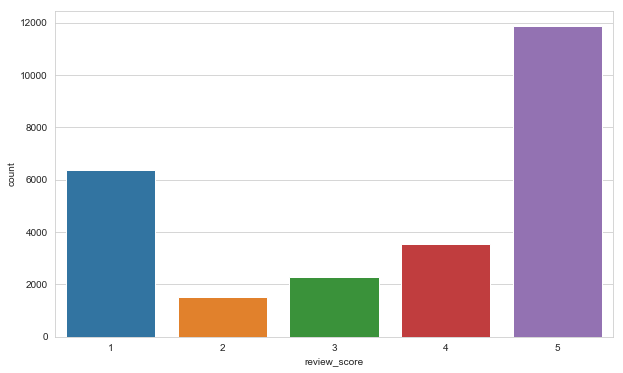

In [108]:
plt.figure(figsize=(10,6))
sns.countplot(NLP_data.review_score)

In [109]:
NLP_good = NLP_data[NLP_data.review_score>3]
print('Number of reviews with score 4 or 5:',NLP_good.shape[0])
NLP_bad = NLP_data[NLP_data.review_score<=3]
print('Number of reviews with score between 1 and 3:',NLP_bad.shape[0])

Number of reviews with score 4 or 5: 15429
Number of reviews with score between 1 and 3: 10141


### WordClouds

One of the easiest way to get an overview of textual data is wordclouds. They are a visual representation of text where the size of the word is scaled with the frequency of the word in the data.

**Function for WordClouds** - From Lecture

In [110]:
def show_wordcloud(data, title,column):
    text = ' '.join(data[column].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,
        max_font_size=100, max_words=100, background_color="white").generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()





From the wordcloud below we see a lot of words occuring often often, e.g. 'produt', 'compr', 'entreb'. <br>
Furthermore we see a lot of of bigrams like 'antrez prazo' and 'produt vei', which we are going to include later in our analysis.

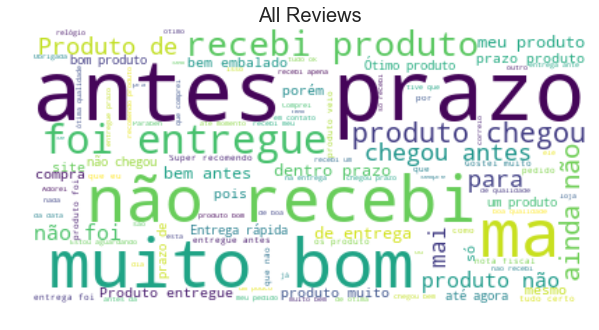

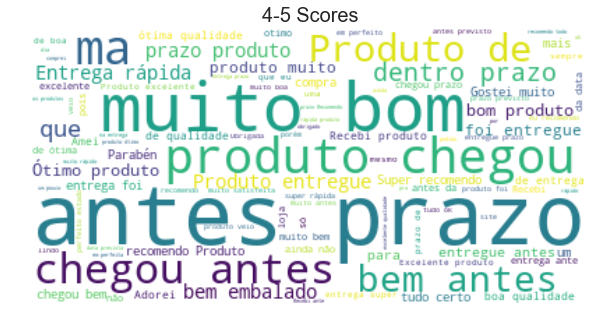

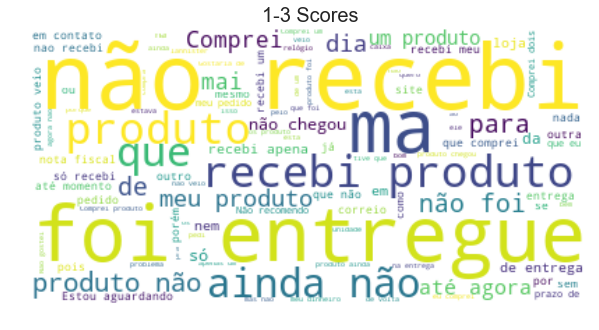

In [111]:
show_wordcloud(NLP_data,'All Reviews','review_comment_message')

show_wordcloud(NLP_good,'4-5 Scores','review_comment_message')

show_wordcloud(NLP_bad,'1-3 Scores','review_comment_message')

#### Review Score over Time
Generally the mean score hovers around 4 over the timespan presented. There is a drop in review scores late 2016 and some outlier values on specific dates. As we using the mean review score the low values on specific dates could be due to a low number of orders (maybe just 1) with low reviews score(s).

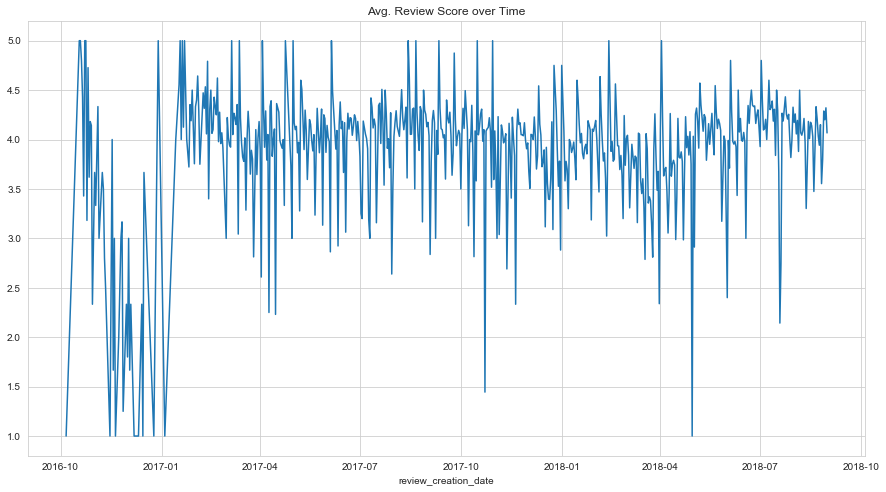

In [112]:
plotdat = df_red.groupby('review_creation_date')['review_score'].mean()
plt.figure(figsize=(15,8))
sns.lineplot(plotdat.index,plotdat.values)
plt.title('Avg. Review Score over Time')
plt.show()

### Average review score by weekday
As the visual above, they all hover around 4 in mean review score. Sunday is the only outlier which is just below 3.5.

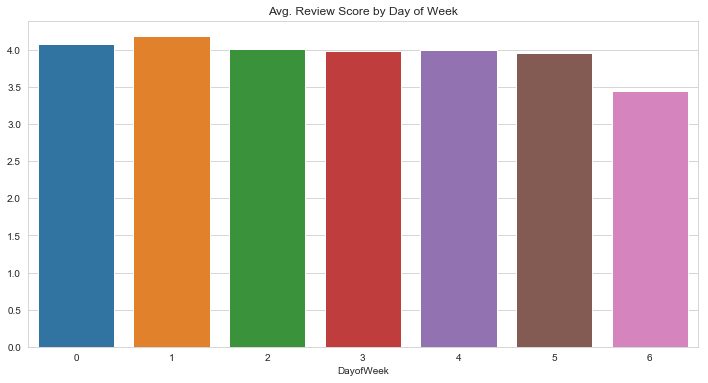

In [113]:
df_red['DayofWeek'] = [i.dayofweek for i in df_red['review_creation_date']]
plotdat = df_red.groupby('DayofWeek')['review_score'].mean()
plt.figure(figsize=(12,6))
sns.barplot(plotdat.index,plotdat.values)
plt.title('Avg. Review Score by Day of Week')
plt.show()

## Data Cleaning

### Duplicates

Our first step in cleaning the data is to remove duplicates. Here we are assuming that the possibility of two individual reviews would never be phrased the exact same way, therefor categorising them as wrong data.


In [114]:
print('Number of duplicate values:', NLP_data[NLP_data.duplicated(subset='review_comment_message', keep='first') == True].shape[0])

Number of duplicate values: 5192


In [115]:
NLP_data = NLP_data[NLP_data.duplicated(subset='review_comment_message', keep='first') == False]
print('Number of observations after removal of duplicates:', NLP_data.shape[0])

Number of observations after removal of duplicates: 20378


#### Define functions for cleaning data

The following function applies the normal proceduceres when cleaning textual data, which includes removing punctuation, removing stopwords and stemming the data. Finally we are removing numbers as they are confusing the translation later in the notebook. <br>
<br>
*Stemming vs. Lemmatizing* <br>
Based on [this site](https://lars76.github.io/nlp/lemmatize-portuguese/) no good lemmatizing-package is available in portugese, thus we decided not to incoorperate lemmatizing. The function is included if able to find a proper package for that. <br>
There are some limitations coming up when choosing to stem vs. lemmatize, as stemming does not always return a real word (e.g. 'compra' -> 'compr'), this makes it harder to interprete for non portugese speakers due to the translation API not working with stemmed words. But as we do not want the algorithm to differ between 'compra' and 'comprei' we are doing stemming and then reversestemming the results, translating and interpreting the topics through that.<br>

In [116]:
st = RSLPStemmer()
def stemText(i):
    i = ' '.join([st.stem(word) for word in i.split()])
    return(i)
def cleanText(i):
    i = ''.join(ch for ch in i if ch not in set(string.punctuation))
    i = ' '.join([word for word in i.split() if word not in portugese_stopwords])
    #i = " ".join([lemmatizer.lemmatize(w) for w in i.split()])
    i = ''.join([ch for ch in i if not ch.isdigit()])
    return i

In [117]:
#Applying the function and defining a new column for cleaned data (cleanReview).
NLP_data = NLP_data.sample(frac=0.5)
NLP_data['cleanReview'] = NLP_data['review_comment_message'].apply(cleanText)
NLP_data.head()

review_comment_message  review_score  \
33879  Produto entregue conforme pedido. Muito boa a ...             5   
44707                            Fui muito bem atendida.             5   
79559       Só tem um problema. Ela está marcando errado             1   
46210  Adorei o produto! Veio bem embalado! Recomendo...             5   
98881  Um dos produtos não foi entregue, estou no agu...             2   

                                             cleanReview  
33879  Produto entregue conforme pedido Muito boa compra  
44707                                   Fui bem atendida  
79559                    Só problema Ela marcando errado  
46210  Adorei produto Veio bem embalado Recomendo ven...  
98881                       Um produtos entregue aguardo

### Creating dictionary for reverse stemming
As we seek to interpret the results, we need to do backwards stemming to the topics, so we can determine the content of each topic later by translating it to english.

In [118]:
#Get all unique words in data
unique_words = set(NLP_data['cleanReview'].str.cat(sep=' ').lower().split())

In [119]:
#Remove all words which only contains special characters
def check(s):
    return all(i in string.punctuation for i in s)
unique_words = [i for i in unique_words if check(i) == False]

In [120]:
stem2word = {}
for word in unique_words:
    word = ''.join(ch for ch in word if ch not in set(string.punctuation))
    word_stem = st.stem(word)
    stem2word.update( {word_stem: word})


In [121]:
stem2word = pd.DataFrame.from_dict(stem2word,orient='index')
stem2word

0
ddeix            ddeixa
lamp           lampadas
concentr    concentrado
xing               xing
mta                 mta
...                 ...
identifiqu  identifique
ral           ralezinho
árdu              árduo
sint              sinto
aprensent   aprensentou

[5234 rows x 1 columns]

In [122]:
#Stemming the data for further use
NLP_data['cleanReview'] = NLP_data['cleanReview'].apply(stemText)

#Splitting again on cleaned data
NLP_good = NLP_data[NLP_data.review_score>3]
print('Number of reviews with score 4 or 5:',NLP_good.shape[0])
NLP_bad = NLP_data[NLP_data.review_score<=3]
print('Number of reviews with score between 1 and 3:',NLP_bad.shape[0])

Number of reviews with score 4 or 5: 6030
Number of reviews with score between 1 and 3: 4159


## Transformation of Data

In this section we are looking into creating Bag of Words (BoW) and Term Frequency–Inverse Document Frequency (TF-IDF) of our data. The motivation for applying TF-IDF as well, is that we saw specific words appear very often in the wordcloud and these will due to their high frequency not explain a lot of variance, so using weighted data will be needed. <br>
Both are a matrix with the dimensions of number of reviews times number of unique words in the data. The Bag of Words simply counts the number of times a word occurs in the specific review. <br>
The TF-IDF is a bit more complex and instead of only counting the number of occurences it weights them with regards to the frequency of the word in the whole dataset. The calculation is for each word in a review the review-frequency of the word is timed the inverse data-frequency of the word. In the following formula $i$ to a word, $x$ refers to a document and $S$ to the set of documents (corpus).
$$\text{TF-IDF}(i,x,S) = TF(i,x) \cdot IDF(i,S)$$
where:
$$\text{TF}(i,x) = count(i \in X)$$
<br>
$$\text{IDF}(i,S) = log(\frac{N}{count(x \in S : i \in S)})$$
[Source](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) <br>

### Bag of Words

In [123]:
count_vect = CountVectorizer(ngram_range=(1,3),min_df=3)
bow_counts = count_vect.fit_transform(NLP_data['cleanReview'].values)

In [124]:
print('Number of unique words in data:', len(count_vect.vocabulary_))
print('First observation includes the words in the following positions of the matrix:','\n',bow_counts[0])

Number of unique words in data: 6748
First observation includes the words in the following positions of the matrix: 
   (0, 4756)	1
  (0, 2157)	1
  (0, 1402)	1
  (0, 4140)	1
  (0, 3638)	1
  (0, 674)	1
  (0, 1159)	1
  (0, 4932)	1
  (0, 2208)	1
  (0, 1414)	1
  (0, 4175)	1
  (0, 3643)	1
  (0, 675)	1
  (0, 4940)	1
  (0, 2210)	1
  (0, 3644)	1


### TF-IDF

In [125]:
tf_transformer = TfidfTransformer()
bow_tfidf = tf_transformer.fit_transform(bow_counts)

In [126]:
print('First observation includes words with the following inverse frequency:','\n',bow_tfidf[0])

First observation includes words with the following inverse frequency: 
   (0, 4940)	0.32186701690789077
  (0, 4932)	0.1622110920234477
  (0, 4756)	0.07182199695898574
  (0, 4175)	0.35001298891445287
  (0, 4140)	0.1563631925279524
  (0, 3644)	0.3590739680612784
  (0, 3643)	0.286317685877968
  (0, 3638)	0.16111144114969547
  (0, 2210)	0.3590739680612784
  (0, 2208)	0.286317685877968
  (0, 2157)	0.09110690119318933
  (0, 1414)	0.3082042070191229
  (0, 1402)	0.19472390170089054
  (0, 1159)	0.10949578887902715
  (0, 675)	0.29173986884893666
  (0, 674)	0.17855617591045927


In [127]:
#Define function for later use. The above is used as examples.
def tf_idf_trans(data):
    count_vect = CountVectorizer(ngram_range=(1,3),min_df=3)
    bow_counts = count_vect.fit_transform(data.values)
    tf_transformer = TfidfTransformer()
    bow_tfidf = tf_transformer.fit_transform(bow_counts)
    return(bow_tfidf)

## Topic Modelling

For topic modelling we are using the package called [Gensim](https://radimrehurek.com/gensim/) as the results are easier extracted than the equiavalent models from *SciKit-Learn*, thus easier to reverse-stem and translate. <br>
Learning about Gensim and how to implement is was mainly inspired from this [github-site](https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb).

### Evaluation of models
To tune the number of topics we are going to use [coherence](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0) af our evaluation parameter. Coherence looks at the semantic similarity between the words scoring high in a topic. If a sentence is coherent to its topic the important words for the topic is present in the sentence. According to [this article](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf?fbclid=IwAR2skjRr_EPVDdW1ltnbuDA-qbcwyaw91zVAm4SvQJaOcx9MB2y-aWbDxUc) 'c_v' is the preferred method, thus this is used in this project. <br>
As the coherence intuitively will keep increasing as the number of topics goes towards the number of documents, we are going to apply what's known as the elbow-method. By looking at the coherence for each model we are going to choose the number of topics where the subsequent scores are increasing less than than previous to the chosen model.

### (LSA and) LDA

**LSA** - Latent Semantic Analysis <br>
This brief theory is introduced as LSA was one of the original algorithms for topic modelling, but it had problems with the interpretability of the results, which LDA solves. It should for the readers give an idea of how the simplest model within Topic Modelling works.<br>
LSA is based on dimensionality reduction. Instead of having our massive TF-IDF matrix, $D$, three new matrics will be introduced using singular value decomposition so the following equation is valid:
$$A = U \Sigma T^*$$
Where
* $U$ is a document-topic map (“topic distribution”) - dimension: $N_{documents} \times N_{documents}$
* $\Sigma$ is an ordered diagonal matrix of singular values (“topic importance”) - dimension: $N_{documents} \times N_{topics}$
* $T$ is a term-topic map (“term distribution”) - dimension: $N_{topics} \times N_{topics}$

As $\Sigma$ is ordered from highest to lowest value (importance) choosing the *K* top rows (topics) of matrix $T^*$ will force a truncation of $U$ and $\Sigma$, to dimensions of respectively: $N_{documents} \times K$ and $K \times K$. <br>
The pros of LSA is that the reduction in dimensionality makes further computations more efficient and it only keeps the most valuable information in the data. The cons are that the algorithm is computionally heavy and results can be hard to interpret. It is important to be aware of information lost when using this algorithm, as it can reduce the data quite heavily.<br>
<br>

For topic modelling in this report we are going to use **LDA** - Latent Dirichlet Allocation <br>
Based on Bayesian theory LDA creates topic based on probabilistic models. It used priors drawn from the Dirichlet function to get the distributions for the document-topic and the word-topic. The mathematical calculations are based on the following formula:

$$\prod_{I=1}^K P(\varphi_i; \beta) \prod_{j=1}^M P(\theta_j;\alpha) \prod_{t=1}^N P(Z_{j,t} | \theta_j)  P(W_{j,t} | \varphi_{z_{j,y}})$$

The *Generative Story* is as follows ([Source](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)):<br>
* Choose $\theta_i \sim Dir(\alpha)$, where $i \in \{1,\dots,N_{documents}\}$
* Choose $\varphi_k \sim Dir(\beta)$, where $k \in \{1,K\}$
* For each document $i \in \{1,\dots,N_{documents}\}$ and each word in document $j \in \{1,\dots,N_i\}$
    * Choose a topic $z_{i,j} \sim Multinomial(\theta_i)$
    * Choose a word $w_{i,j} \sim Multinomial(\varphi_{z_{j,y}})$

The motivation for doing a Bayesian model is that instead of creating topics based on the data, it creates functions with belonging distributions from which the data could have been drawn/gathered. It initializes by randomly assigning a topic to each document. It then calculates the proportion of words in a document assigned to a specific topic, followed by calculating the proportion of assigned documents to the specific topic of all documents with a specific word. Based on these values the document will be assigned a new topic if needed, and this procedure will be repeated untill a steady state where no topics is being assigned new topics is reached. <br>
<br>
The LDA model has three hyperparameters:
* Number of topics
* $\alpha$ - parameter for the dirichlet-function for topics
* $\beta$ - parameter for the dirichlet-function for words

### Converting data to right format
Instead of a single string Gensim needs every input to be an array of words for each review. This is applied below by splitting each review.

In [128]:
#Example
f = lambda x: x["cleanReview"].split()
xx = NLP_data.apply(f, axis=1).head(5)
xx

33879     [produt, entreg, conform, ped, muit, boa, compr]
44707                                    [fui, bem, atend]
79559                        [só, problem, ela, marc, err]
46210    [ador, produt, vei, bem, embal, recom, vend, o...
98881                         [um, produt, entreg, aguard]
dtype: object

**Multigram** <br>
Instead of only looking at occurences of single words we are including both bi- and trigrams, which means the model is also looking into phrases of two and three words. This is done so we catch the difference in e.g. 'late delivery' and 'early delivery', which without bigram would go together under 'delivery'.

In [129]:
tokens = xx.tolist()
bigram_model = models.Phrases(tokens)
trigram_model = models.Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

**Creating TF-IDF matrix** <br>
We are filtering out any words which occur in less than three reviews, as we see these as being to specific for a general topic.

In [130]:
dictionary = corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=3) #Do not include words which is in less than 3 reviews
corpus = [dictionary.doc2bow(tok) for tok in tokens]
tfidf = models.TfidfModel(corpus, normalize=True)
corpus = tfidf[corpus]

In [131]:
#As a function
def gensim_data_convert(data):
    f = lambda x: x['cleanReview'].split()
    xx = data.apply(f, axis=1)
    tokens = xx.tolist()
    bigram_model = models.Phrases(tokens)
    trigram_model = models.Phrases(bigram_model[tokens], min_count=1)
    tokens = list(trigram_model[bigram_model[tokens]])
    dictionary = corpora.Dictionary(tokens)
    dictionary.filter_extremes(no_below=3) #Do not include words which is in less than 3 reviews
    corpus = [dictionary.doc2bow(tok) for tok in tokens]
    tfidf = models.TfidfModel(corpus, normalize=True)
    corpus = tfidf[corpus]
    
    return(tokens,dictionary,corpus)

In [132]:
allData_tokens, allData_dictionary, allData_corpus = gensim_data_convert(NLP_data)
good_tokens, good_dictionary, good_corpus = gensim_data_convert(NLP_good)
bad_tokens, bad_dictionary, bad_corpus = gensim_data_convert(NLP_bad)
print('Output and format of TF-IDF corpus for review:')
allData_corpus[1]

Output and format of TF-IDF corpus for review:


[(6, 0.4345251417014382), (7, 0.9006597033449122)]

### Functions

A function to return the probabilities of a review being in a category as a dataframe.

In [133]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

def document_topic(model,documentNum,corp):
    topics = [model[corp[i]] for i in range(documentNum)]
    xx = pd.concat([topics_document_to_dataframe(topics_document, num_topics=model.num_topics) for topics_document in topics]) \
      .reset_index(drop=True).fillna(0)
    return xx

The functions in the following cell does the following:
* Converts a stemmed word back to its original form
* Ensures that the following functions works with multigrams and translates top words in each topic from Gensim-model.
* Converts format to right output for translation, using regular expression  RegEx is needed as the out put is long strings with various special characters and numbers.
* Third function applies it to a dataframe for easier readability.

In [134]:
import re

#Function for reverse stemming using the dictionary from earlier
def reverseStem(i):
    for stem, word in stem2word.iterrows():
        #print(stem)
        #print(word)
        if i == stem:
            return(word)


def multigram(string):
    x = re.split(r'_', string)
    xx = list()
    for i in range(len(x)):
        #print(x[i])
        yy = reverseStem(x[i])[0]
        yy = translator.translate(yy,dest='en').text
        xx.append(yy)
    #print(xx)
    y = '_'.join(xx)
    return(y)


def translateTopic(topicNum,num_words,model):
    res = []
    for i in range(int(num_words)):
        s = model.show_topics(formatted=True, num_topics=model.num_topics, num_words=topWords)[topicNum][1].split()[2*i]
        numberpattern = "\d+\.\d+"
        pattern = "\"(.*?)\""
        substring = re.search(pattern, s).group(1)
        #Reverse stem for multigrams
        trans = multigram(substring)
        number = re.search(numberpattern, s).group(0)
        x = [trans,number]
        res.append(x)
    return res


def translateDataFrame(model):
    items= {}
    for i in range(num_topics):
        print('Translating topic:',i)
        g = translateTopic(i,topWords,model)
        items.update( {'Topic {}'.format(i) : g})
    items = pd.DataFrame.from_dict(items)
    return items

### LDA - Latent Dirichlet Analysis

As explained earlier the LDA has three parameters we are going to tune. Instead of tuning all three at once, we are intially tuning the number of topics using the default values for $\alpha$ and $\beta$. This is due to the number of topics being dominant compared to the two others, so the final score will not be highly effected by tuning step by step.

#### Good Reviews (4-5)

In [136]:
start = 2 #Min topic
stop = 20 #Max topic

coh_topic = {}
for i in range(start,stop):
    lda_model = models.LdaModel(good_corpus, num_topics=i, id2word=good_dictionary, passes=4, alpha=[0.01]*i, eta=[0.01]*len(good_dictionary.keys()),random_state=42)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=good_tokens, dictionary=good_dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score for {} topics: '.format(i), coherence_lda)
    
    coh_topic.update( {i: coherence_lda})
    
coh_topic_good = pd.DataFrame.from_dict(coh_topic,orient='index')
coh_topic_good.index.names = ['NumTopic']
coh_topic_good.rename(columns = {coh_topic_good.columns[0]:'Coherence'}, inplace = True)


Coherence Score for 2 topics:  0.26288413289026236

Coherence Score for 3 topics:  0.38275238241788534

Coherence Score for 4 topics:  0.37364080651307735

Coherence Score for 5 topics:  0.33643807392631614

Coherence Score for 6 topics:  0.3089441821355434

Coherence Score for 7 topics:  0.3230466524214414

Coherence Score for 8 topics:  0.3300352044672515

Coherence Score for 9 topics:  0.33778542755784563

Coherence Score for 10 topics:  0.3472682446850773

Coherence Score for 11 topics:  0.34308971128874854

Coherence Score for 12 topics:  0.35132007126994663

Coherence Score for 13 topics:  0.35206999752767854

Coherence Score for 14 topics:  0.32815964929467917

Coherence Score for 15 topics:  0.33930488857709573

Coherence Score for 16 topics:  0.3591301857068102

Coherence Score for 17 topics:  0.3662607890561934

Coherence Score for 18 topics:  0.38103634966588834

Coherence Score for 19 topics:  0.37498258818257246


In [139]:
choiceNum = 3

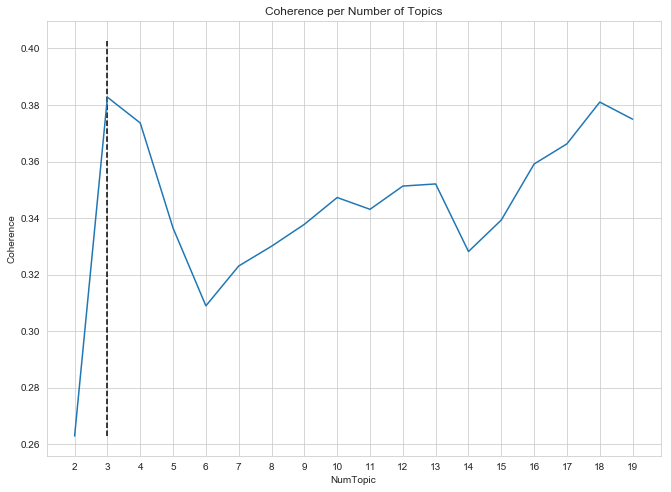

In [143]:
plt.figure(figsize=(11,8))
sns.lineplot(coh_topic_good.index,coh_topic_good.Coherence)
plt.title('Coherence per Number of Topics')
plt.vlines(choiceNum,coh_topic_good.Coherence.min(),coh_topic_good.Coherence.max()+0.02,linestyles='dashed')
plt.xticks(range(2,20, 1))
plt.show()

From above we estimate the number of topics for the good reviews to be 3 as the increase in coherence is rather lower afterwards. Below we are applying final parametertuning to model by gridsearching over different values of $\alpha$ and $\beta$. This method can be critisised as in an optimal world a gridsearch for each topic would be applied and the maximal coherence extracted, but due to computer limitations it is in our case applied sequentially.

In [144]:
#Final parameter tuning

num_topics = choiceNum #Number of topics
alpha = list(np.arange(0.01, 1, 0.2))
beta = list(np.arange(0.01, 1, 0.2))

parameterTuning_good = pd.DataFrame(columns=['Alpha','Beta','Coherence Score'])

for i in range(len(alpha)):
    for j in range(len(beta)):
        lda_model = models.LdaModel(good_corpus, num_topics=num_topics, id2word=good_dictionary, passes=4, alpha = alpha[i], eta=beta[j],random_state=42)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=good_tokens, dictionary=good_dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print('\nCoherence Score for Alpha {} and Beta: {}: '.format(alpha[i],beta[j]), coherence_lda)

        parameterTuning_good = parameterTuning_good.append({'Alpha': alpha[i],'Beta' : beta[j], 'Coherence Score' : coherence_lda},ignore_index=True)


Coherence Score for Alpha 0.01 and Beta: 0.01:  0.38275238241788534

Coherence Score for Alpha 0.01 and Beta: 0.21000000000000002:  0.3525644497721873

Coherence Score for Alpha 0.01 and Beta: 0.41000000000000003:  0.3687915056809099

Coherence Score for Alpha 0.01 and Beta: 0.6100000000000001:  0.3698527492938441

Coherence Score for Alpha 0.01 and Beta: 0.81:  0.37375412314775175

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.01:  0.3604692783004549

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.21000000000000002:  0.35999707284917676

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.41000000000000003:  0.3647944374962518

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.6100000000000001:  0.3592173289226637

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.81:  0.3488673674746127

Coherence Score for Alpha 0.41000000000000003 and Beta: 0.01:  0.3285353807896721

Coherence Score for Alpha 0.41000000000000003 and Beta: 0.210000000000

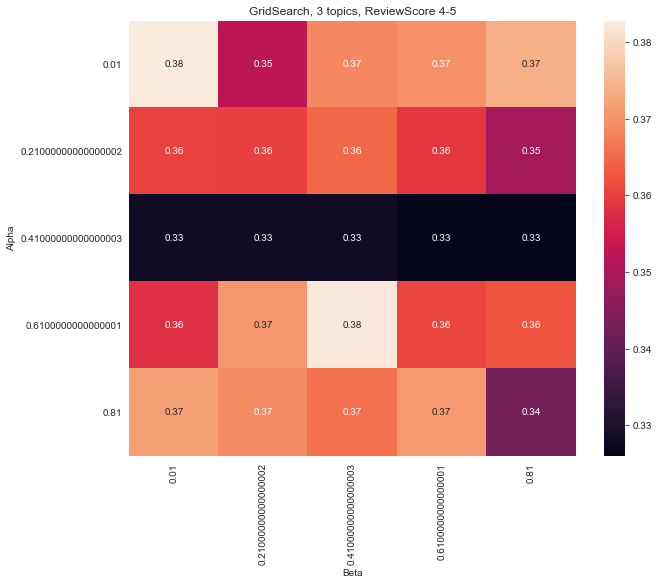

In [145]:
plt.figure(figsize=(10,8))
sns.heatmap(parameterTuning_good.pivot('Alpha','Beta',values = 'Coherence Score'),annot=True)
plt.title('GridSearch, {} topics, ReviewScore 4-5'.format(choiceNum))
plt.show()

Train last model with optimal parameters

In [146]:
#Create final model for further use
num_topics = choiceNum #Number of topics
alpha = parameterTuning_good.iloc[parameterTuning_good['Coherence Score'].idxmax()]['Alpha']
beta = parameterTuning_good.iloc[parameterTuning_good['Coherence Score'].idxmax()]['Beta']
print('Final model with alpha {}, beta {} and {} topics'.format(alpha,beta,num_topics))
lda_model_good = models.LdaModel(good_corpus, num_topics=num_topics, id2word=good_dictionary, passes=4, alpha = alpha, eta=beta,random_state=42)

Final model with alpha 0.01, beta 0.01 and 3 topics


#### Bad/Neutral Reviews (1-3)

In [147]:
start = 2 #Min topic
stop = 20 #Max topic

coh_topic = {}
for i in range(start,stop):
    lda_model = models.LdaModel(bad_corpus, num_topics=i, id2word=bad_dictionary, passes=4, alpha=[0.01]*i, eta=[0.01]*len(bad_dictionary.keys()),random_state=42)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=bad_tokens, dictionary=bad_dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score for {} topics: '.format(i), coherence_lda)
    
    coh_topic.update( {i: coherence_lda})
    
coh_topic_bad = pd.DataFrame.from_dict(coh_topic,orient='index')
coh_topic_bad.index.names = ['NumTopic']
coh_topic_bad.rename(columns = {coh_topic_bad.columns[0]:'Coherence'}, inplace = True)


Coherence Score for 2 topics:  0.23032715379468396

Coherence Score for 3 topics:  0.2486066562182847

Coherence Score for 4 topics:  0.2971707792534464

Coherence Score for 5 topics:  0.3108061145355218

Coherence Score for 6 topics:  0.37994972931844506

Coherence Score for 7 topics:  0.35618444838445024

Coherence Score for 8 topics:  0.37725944536715544

Coherence Score for 9 topics:  0.4101622668769751

Coherence Score for 10 topics:  0.39828070684878014

Coherence Score for 11 topics:  0.40803881094731054

Coherence Score for 12 topics:  0.4233094790573755

Coherence Score for 13 topics:  0.4773421260983083

Coherence Score for 14 topics:  0.447061727798506

Coherence Score for 15 topics:  0.46223574568014786

Coherence Score for 16 topics:  0.47328350610263514

Coherence Score for 17 topics:  0.46992431577899474

Coherence Score for 18 topics:  0.461476504135471

Coherence Score for 19 topics:  0.4598293101558949


In [151]:
choiceNum = 6

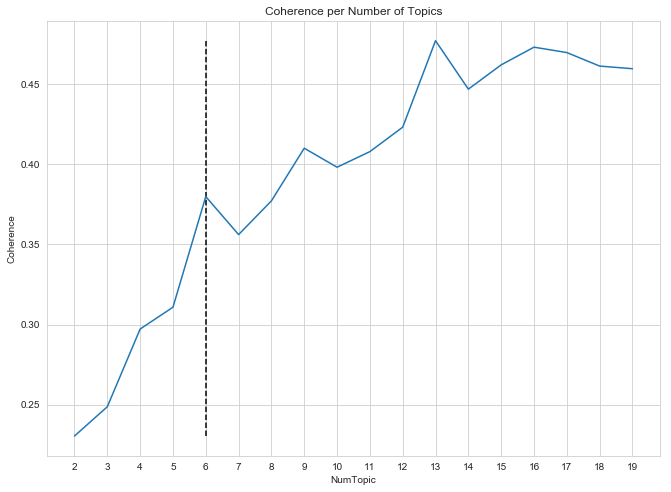

In [152]:
plt.figure(figsize=(11,8))
sns.lineplot(coh_topic_bad.index,coh_topic_bad.Coherence)
plt.title('Coherence per Number of Topics')
plt.vlines(choiceNum,coh_topic_bad.Coherence.min(),coh_topic_bad.Coherence.max(),linestyles='dashed')
plt.xticks(range(2,20, 1))
plt.show()

As for the good reviews we are applying final tuning to the bad/neutral reviews.

In [153]:
#Final parameter tuning

num_topics = choiceNum #Number of topics
alpha = list(np.arange(0.01, 1, 0.2))
beta = list(np.arange(0.01, 1, 0.2))

parameterTuning_bad = pd.DataFrame(columns=['Alpha','Beta','Coherence Score'])

for i in range(len(alpha)):
    for j in range(len(beta)):
        lda_model = models.LdaModel(bad_corpus, num_topics=num_topics, id2word=bad_dictionary, passes=4, alpha = alpha[i], eta=beta[j],random_state=42)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=bad_tokens, dictionary=bad_dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print('\nCoherence Score for Alpha {} and Beta: {}: '.format(alpha[i],beta[j]), coherence_lda)

        parameterTuning_bad = parameterTuning_bad.append({'Alpha': alpha[i],'Beta' : beta[j], 'Coherence Score' : coherence_lda},ignore_index=True)


Coherence Score for Alpha 0.01 and Beta: 0.01:  0.37994972931844506

Coherence Score for Alpha 0.01 and Beta: 0.21000000000000002:  0.3839418524900839

Coherence Score for Alpha 0.01 and Beta: 0.41000000000000003:  0.3720223883435345

Coherence Score for Alpha 0.01 and Beta: 0.6100000000000001:  0.38580455467304686

Coherence Score for Alpha 0.01 and Beta: 0.81:  0.3339510603526172

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.01:  0.32965133324387996

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.21000000000000002:  0.3369336496597277

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.41000000000000003:  0.36137513327824883

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.6100000000000001:  0.32434692717689767

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.81:  0.3254432767075565

Coherence Score for Alpha 0.41000000000000003 and Beta: 0.01:  0.2966134922179931

Coherence Score for Alpha 0.41000000000000003 and Beta: 0.2100000000

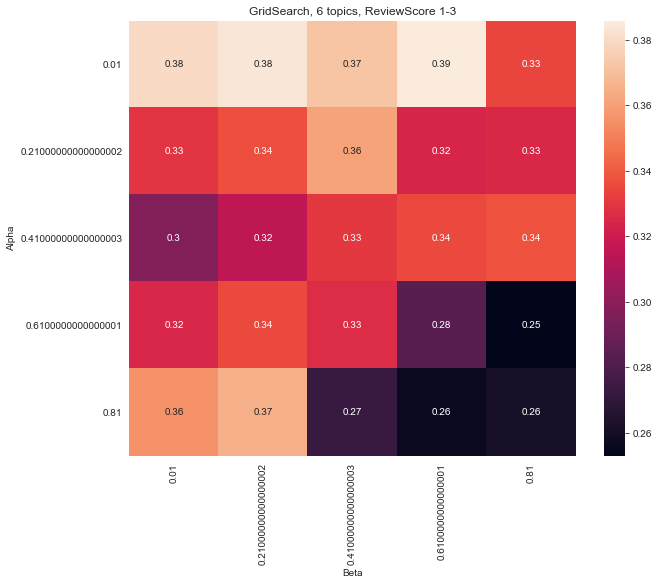

In [154]:
plt.figure(figsize=(10,8))
sns.heatmap(parameterTuning_bad.pivot('Alpha','Beta',values = 'Coherence Score'),annot=True)
plt.title('GridSearch, {} topics, ReviewScore 1-3'.format(choiceNum))
plt.show()

In [155]:
#Create final model for further use
num_topics = choiceNum #Number of topics
alpha = parameterTuning_bad.iloc[parameterTuning_bad['Coherence Score'].idxmax()]['Alpha']
beta = parameterTuning_bad.iloc[parameterTuning_bad['Coherence Score'].idxmax()]['Beta']
print('Final model with alpha {}, beta {} and {} topics'.format(alpha,beta,num_topics))
lda_model_bad = models.LdaModel(bad_corpus, num_topics=num_topics, id2word=bad_dictionary, passes=4, alpha = alpha, eta=beta,random_state=42)

Final model with alpha 0.01, beta 0.6100000000000001 and 6 topics


### Predict topics
We now calculate how much each review is in each topic and take the maximum value and predict that review to being in that topic. The tables below refere to how much the review fits into a topic. Thus if one has 0.49 for topic 2 and 0.51 for topic 5 it is likely a combination of the two topics defining the review.

#### Good Reviews (4-5)

In [157]:
good_topic_dist = document_topic(lda_model_good,len(NLP_good),good_corpus)
good_topic_dist.index = NLP_good.index
NLP_good['LDA_TopicPred'] = good_topic_dist.idxmax(axis=1)
good_topic_dist

0         1         2
33879  0.523989  0.000000  0.470562
44707  0.000000  0.000000  0.985380
46210  0.833672  0.000000  0.162350
89481  0.000000  0.988268  0.000000
46838  0.000000  0.990473  0.000000
...         ...       ...       ...
39340  0.000000  0.989031  0.000000
57057  0.000000  0.000000  0.992456
64362  0.000000  0.990244  0.000000
75796  0.000000  0.000000  0.988987
91746  0.000000  0.000000  0.988235

[6030 rows x 3 columns]

In [158]:
NLP_good.head()

review_comment_message  review_score  \
33879  Produto entregue conforme pedido. Muito boa a ...             5   
44707                            Fui muito bem atendida.             5   
46210  Adorei o produto! Veio bem embalado! Recomendo...             5   
89481                                     GOSTEI DE TUDO             5   
46838      Gostei do produto e a entrega foi bem rápida!             5   

                                      cleanReview  LDA_TopicPred  
33879    produt entreg conform ped muit boa compr              0  
44707                               fui bem atend              2  
46210  ador produt vei bem embal recom vend obrig              0  
89481                                 gost de tud              1  
46838                gost produt entreg bem rápid              1

Quick overview of the frequency of the different topics, which shows topic 4 being the most frequent.

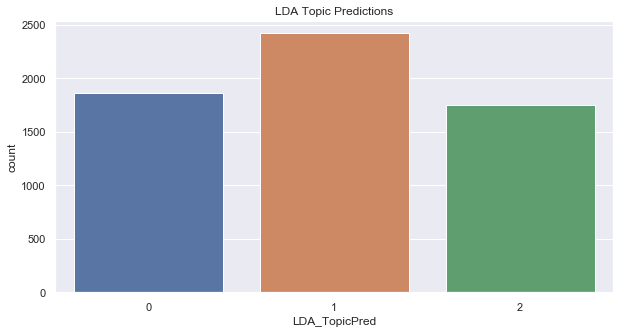

In [159]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(NLP_good['LDA_TopicPred'])
plt.title('LDA Topic Predictions')
plt.show()

From the average score presented below we see that topi 2,3 and 5 are quite lower than the others. Which means these topics are more likely to have a score of 4 than 5.

In [160]:
print('Avg. review score for each Topic:')
print(NLP_good.groupby('LDA_TopicPred')['review_score'].mean())

Avg. review score for each Topic:
LDA_TopicPred
0    4.775335
1    4.793546
2    4.728833
Name: review_score, dtype: float64


#### Bad/Neutral Reviews (1-3)

In [161]:
bad_topic_dist = document_topic(lda_model_bad,len(NLP_bad),bad_corpus)
bad_topic_dist.index = NLP_bad.index
NLP_bad['LDA_TopicPred'] = bad_topic_dist.idxmax(axis=1)
bad_topic_dist

0         1         2         3         4         5
79559   0.000000  0.000000  0.000000  0.000000  0.000000  0.975569
98881   0.000000  0.435435  0.000000  0.000000  0.541829  0.000000
64812   0.000000  0.000000  0.959603  0.000000  0.000000  0.000000
94190   0.000000  0.000000  0.000000  0.975708  0.000000  0.000000
38833   0.752707  0.000000  0.000000  0.000000  0.000000  0.235633
...          ...       ...       ...       ...       ...       ...
110995  0.972715  0.000000  0.000000  0.000000  0.000000  0.000000
63736   0.984608  0.000000  0.000000  0.000000  0.000000  0.000000
9845    0.000000  0.972048  0.000000  0.000000  0.000000  0.000000
90371   0.000000  0.000000  0.000000  0.000000  0.000000  0.983481
81446   0.980165  0.000000  0.000000  0.000000  0.000000  0.000000

[4159 rows x 6 columns]

In [162]:
NLP_bad.head()

review_comment_message  review_score  \
79559       Só tem um problema. Ela está marcando errado             1   
98881  Um dos produtos não foi entregue, estou no agu...             2   
64812                                 Gostei do produto!             3   
94190  Comprei o produto e não recebi já vai fazer um...             1   
38833  Recebi produto errado. Necessito urgente que s...             2   

                                             cleanReview  LDA_TopicPred  
79559                            só problem ela marc err              5  
98881                            um produt entreg aguard              4  
64812                                        gost produt              2  
94190      compr produt receb vai faz mêsmuit ruim recom              3  
38833  receb produt err necessit urgent feit troc est...              0

Quick overview of the frequency of the different topics. The distribution of topics is not completely even as topic 2 and 3 is a quite a bit less frequent.

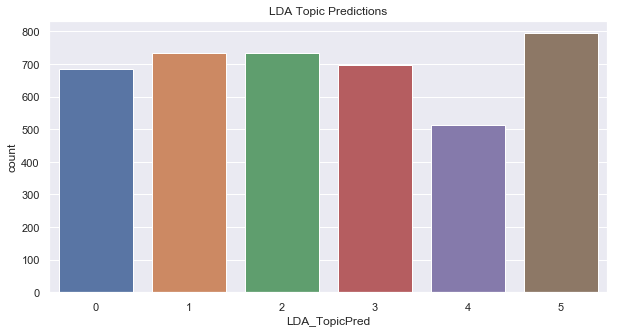

In [163]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(NLP_bad['LDA_TopicPred'])
plt.title('LDA Topic Predictions')
plt.show()

Looking at the average scores they are all quite alike. It can be argued that topic 0 and 2 are a bit higher than the others, thus the probability of having a review score of 3 when in of the two topics are higher.

In [164]:
print('Avg. review score for each Topic:')
print(NLP_bad.groupby('LDA_TopicPred')['review_score'].mean())

Avg. review score for each Topic:
LDA_TopicPred
0    1.559942
1    1.559184
2    1.463946
3    1.585960
4    1.674464
5    1.721662
Name: review_score, dtype: float64


### Interpretation of topics
In the following section we are looking into applying some general interpretation to each topic. This is done by reverse stemming and translating the top words og multigrams in each topic. Afterwards we are using a classification model to see which topics contributes most to a high review score.

#### Good Reviews (4-5)

In [166]:
num_topics = 3
topWords = 25 #Number of words to translate for each topic
translateTopWords_good = translateDataFrame(lda_model_good)
translateTopWords_good

Translating topic: 0
Translating topic: 1
Translating topic: 2


Topic 0                        Topic 1  \
0           [deliveries, 0.044]                 [bomeu, 0.055]   
1             [producer, 0.042]            [They liked, 0.051]   
2                [great, 0.038]                  [term, 0.036]   
3                 [term, 0.036]              [producer, 0.036]   
4          [beats_Quick, 0.033]            [deliveries, 0.033]   
5            [delighted, 0.031]             [Excellent, 0.029]   
6          [I recommend, 0.028]                 [great, 0.029]   
7               [all_ok, 0.028]                [prissy, 0.028]   
8               [before, 0.026]                   [was, 0.025]   
9          [good_packed, 0.026]                [before, 0.025]   
10          [to receive, 0.025]               [chegare, 0.023]   
11          [all_prissy, 0.025]                  [good, 0.021]   
12           [qualities, 0.024]                [bought, 0.020]   
13                  [ok, 0.023]           [I recommend, 0.020]   
14   [tree_expectations, 0.022]               [in love, 0.019]   
15             [correct, 0.022]                [stores, 0.017]   
16                   [O, 0.020]              [finished, 0.015]   
17         [all_perfect, 0.020]                  [boas, 0.015]   
18           [requested, 0.020]                 [Quick, 0.015]   
19             [company, 0.019]  [seem_being_resistant, 0.014]   
20                [tree, 0.018]               [waiting, 0.013]   
21             [however, 0.018]           [responsible, 0.013]   
22                   [I, 0.018]                 [light, 0.012]   
23             [waiting, 0.016]                     [I, 0.011]   
24  [comply_I shall ask, 0.013]                 [beats, 0.011]   

                     Topic 2  
0        [very_bomeu, 0.046]  
1             [diaas, 0.034]  
2          [combined, 0.031]  
3           [perfect, 0.025]  
4            [always, 0.024]  
5          [practice, 0.022]  
6         [very_boas, 0.021]  
7           [chegare, 0.021]  
8               [all, 0.021]  
9       [I recommend, 0.020]  
10         [producer, 0.019]  
11  [continue_always, 0.018]  
12       [to receive, 0.017]  
13          [fragile, 0.016]  
14              [mto, 0.016]  
15             [term, 0.016]  
16             [note, 0.015]  
17       [obligation, 0.015]  
18       [deliveries, 0.015]  
19                [O, 0.015]  
20           [bought, 0.015]  
21            [think, 0.014]  
22        [like this, 0.014]  
23           [before, 0.013]  
24             [hood, 0.013]

Above is the 25 highest weighted words or phrases for each of the three topics. It is noted that both 'bomeu' and 'boas' are not translated, but are words for 'good'.
* <b> Topic 0: </b>
The most notable words or phrases for this topic is:
    1. *deliveries*
    1. *beats_quick*
    2. *good_packed*

    The majority of important words and phrases are just positive adjectives. From the three noted words it can be argued that this topic regards the delivery of the orders. All three words is within the delivery and packaging part of the order-process and together with all the positive adjectives the reviews in this topic is positive feedback to the delivery and packaging service.<br>
    <br>
    
* <b> Topic 1: </b>
The most notable words or phrases for this topic is:
    1. *deliveries*
    
    This topic seems to mainly consist of adjectives, which makes it hard to assign a category to the topic. We do see the word 'deliveries', which again indicates reviews positive about the delivery of the item. Apart from that the reviews in this topics appears to be just complimenting their received orders.<br>
    <br>

* <b> Topic 2: </b>
The most notable words or phrases for this topic is:
    1. *chegare (trans: 'to arrive)*
    2. *deliveries*
    3. *hood*
    
    Topic 2 as the two previous mainly contains positive adjectives and words regarding delivery. This only specific setting it apart is 'hood' which indicates positive reviews regarding hoods are present.<br>
    <br>

##### Rating topics by feature importance using classification-algorithm
The last step in interpreting the topics is to use the output of the LDA as the independent variables for a classification model. As we have unbalanced data we are going to use a balanced random forest classifier. By looking at the feature importance, the more positive the value of the feature is the more it contribute to a higher score.

In [170]:
labels = NLP_good.review_score.unique()

clf = RandomForestClassifier(random_state=42, class_weight="balanced")
clf.fit(good_topic_dist,NLP_good['review_score'])

names = np.arange(0,good_topic_dist.shape[1])
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.3763, 1), (0.3255, 2), (0.2982, 0)]


From the above scores it can be derived that topic 1 has the highest feature importance in the classification algorithm, thus it can be concluded that this topic 1 is most likely to contain reviews with a score of 5, whereas topic 0 is most likely to contain topics with a score of 4.

#### Bad/Neutral Reviews (1-3)

In [168]:
num_topics = 6
topWords = 25 #Number of words to translate for each topic
translateTopWords_bad = translateDataFrame(lda_model_bad)
translateTopWords_bad

Translating topic: 0
Translating topic: 1
Translating topic: 2
Translating topic: 3
Translating topic: 4
Translating topic: 5


Topic 0                      Topic 1  \
0                  [not, 0.020]                [aind, 0.018]   
1             [producer, 0.012]          [to receive, 0.017]   
2           [deliveries, 0.012]                [only, 0.014]   
3           [to receive, 0.009]              [bought, 0.013]   
4              [chegare, 0.008]            [producer, 0.012]   
5    [totally_different, 0.008]                 [you, 0.012]   
6                 [sell, 0.007]            [too much, 0.012]   
7               [bought, 0.007]               [units, 0.010]   
8               [I make, 0.006]  [download_qualities, 0.010]   
9               [stores, 0.006]                 [doi, 0.010]   
10                [data, 0.006]          [deliveries, 0.009]   
11      [I can_evaluate, 0.006]         [bomeu_diaas, 0.008]   
12                [meet, 0.005]         [note_fiscal, 0.008]   
13           [customers, 0.005]                   [I, 0.007]   
14                 [and, 0.005]            [curtains, 0.007]   
15         [I recommend, 0.005]            [I waited, 0.006]   
16           [partially, 0.005]           [requested, 0.006]   
17         [could_being, 0.005]              [paying, 0.006]   
18             [delayed, 0.005]                 [kit, 0.005]   
19        [my_requested, 0.005]                 [set, 0.005]   
20              [warned, 0.005]             [chegare, 0.005]   
21                [item, 0.005]           [announced, 0.005]   
22                   [O, 0.005]              [packed, 0.005]   
23  [qualities_spacious, 0.005]                [done, 0.005]   
24             [through, 0.005]             [missing, 0.005]   

                        Topic 2                    Topic 3  \
0           [to receive, 0.021]            [bought, 0.012]   
1                  [not, 0.019]          [producer, 0.012]   
2             [producer, 0.015]              [send, 0.009]   
3      [up until_moment, 0.014]        [to receive, 0.008]   
4                [diaas, 0.010]           [because, 0.008]   
5                 [aind, 0.008]              [only, 0.007]   
6           [deliveries, 0.008]              [boas, 0.006]   
7                    [a, 0.007]            [moment, 0.006]   
8               [bought, 0.007]        [exchanging, 0.006]   
9               [nephew, 0.007]               [you, 0.006]   
10           [delighted, 0.006]           [chegare, 0.006]   
11           [requested, 0.006]         [completed, 0.005]   
12                 [you, 0.006]        [deliveries, 0.005]   
13             [chegare, 0.006]  [estinho_I waited, 0.005]   
14         [merchandise, 0.006]            [bottle, 0.005]   
15            [bankrupt, 0.006]                 [O, 0.005]   
16             [nothing, 0.005]              [term, 0.005]   
17               [light, 0.005]         [requested, 0.005]   
18           [you_smash, 0.005]             [cores, 0.004]   
19         [tissue_till, 0.005]             [think, 0.004]   
20             [delayed, 0.005]               [now, 0.004]   
21  [information_nephew, 0.005]        [you_defect, 0.004]   
22                [seam, 0.005]      [cloth_meadow, 0.004]   
23                [give, 0.004]          [spacious, 0.004]   
24                [seem, 0.004]        [want_taste, 0.004]   

                                 Topic 4                Topic 5  
0                    [deliveries, 0.008]    [deliveries, 0.014]  
1   [already_I shall ask_returns, 0.007]             [O, 0.012]  
2                            [my, 0.007]      [producer, 0.011]  
3                      [producer, 0.007]        [taking, 0.011]  
4                   [I recommend, 0.007]       [chegare, 0.008]  
5                    [to receive, 0.007]       [missing, 0.008]  
6                        [bought, 0.007]    [to receive, 0.008]  
7                     [requested, 0.006]          [term, 0.007]  
8                      [approved, 0.006]       [waiting, 0.007]  
9                           [one, 0.006]        [bought, 0.007]  
10                  

As for the reviews with a score of 4 or 5, above is the 25 highest weighted words or phrases for each topic for reviews with score 1-3. We see that almost all categories have words or phrases which are delivery-related. This indicates that a lot of the complaints are regarding the delivery. The elaboration of each topic below will therefor not comment on the delivery aspect as it is not topic-specific. The word 'missing' appears a few times aswell, and could be seen as items gone missing through delivery, but as this is not known it is assumed to be items 'missing' from specific orders or not being send. This however, requires a more thorough investigation of the specific reviews to determine.<br>
It should also be noted that there are a few stopwords in the top words like 'a' and 'and'. It is hard to backtrack how these got in there, as according to the list of stopwords should have been removed, but could be due to the translation. These are ignored in the following elaboration aswell.<br>
In the end of each topic it will, if possible, be assigned to teams/departments which if analysis is right would be the right for handling these.
* <b> Topic 0: </b>
The most notable words or phrases for this topic is:
    1. *totally_different*
    1. *data*
    2. *stores*
    
    It appears that this topic regards some orders delivered wrong or items not living up to expectations. This is derived as 'totally_different' is the 6th highest weighted word/phrase and it could refere to people receiving items which were totally different from what they expected. The two other words ntoed are 'data' and 'stores', but without getting into more indepth analysis of the reviews in this topic it is hard to assign an interpretation. It should however be noted, that further analysis should look into this. The rest of the words is not giving any valueable info or regards delivery.<br>
    These reviews should be directed to the team handling returned items, as items not up to expectation could be returned. They should look into some if these orders have patterns and maybe reoccur often for some items.
    <br>
    <br>
    
* <b> Topic 1: </b>
The most notable words or phrases for this topic is:
    1. *too much*
    2. *units*
    3. *download_qualities*
    4. *note_fiscal*
    5. *curtains*
    
    The first two words referes to inaccurate quantity of orders. 'too_much' and 'units' both indicates the topic is concerning quantities, and since these topics regards the worse half of the reviews it is assumed that the quantity of the orders were wrong. 'download_qualities' could be correctly translated, but as the data is reviews for an e-commerceit is going to be assumed that 'download' is a translation for delivery. However, thus should be further investigated by a person fluent in portugese.<br>
    'note_fiscal' is assumed to be a wrongful translation of an invoice, therefor this topic regards invoices. If this is combined with the wrong quantities, it can be argued that the invoices in this topic is complained about due to the wrong quantity being listed. Lastly, 'curtains' appears as one of the top 25 words which means reviews regarding curtains are within this topic aswell.<br>
    The team sending out invoices and handling payment procedure should be assigned the reviews in this topic. The specific reviews for curtains are directed to people handling the sales of curtains.<br>
    <br>

* <b> Topic 2: </b>
The most notable words or phrases for this topic is:
    1. *bankrupt*
    2. *you_smash*
    
    Only two notable words are found in this topic. 'bankrupt' indicates some reviews could be complaints of bankrupt sellers or alike. 'you_smash' seems to a very simplified translation regarding delievered items broken. 'nephew' also seemed to be an important word for this topic, but as no valuable information can be derived it is not going to be mentioned any further.<br>
    This topic should be handled by the financial section within customer service as customers might want a refund if their seller has gone bankrupt. The same goes for broken items.<br>
    <br>
    
* <b> Topic 3: </b>
The most notable words or phrases for this topic is:
    1. *you_defect*
    
    Only phrase noteworthy is the above refering to defect items. These should be directed to the same team as reviews in topic 2. Looking at 'cloth_meadow', a short search shows that 'meadow' is a product line and combined with 'cloth' it could indicate there were reaccuring problems with products from this seller.<br>
    <br>    
    
* <b> Topic 4: </b>
The most notable words or phrases for this topic is:
    1. *already_I shall ask_returns*
    2. *missing*
    3. *watch*
    
    This topic stands out a bit from the others, as it has no word or phrases with a weight above 0.01. All top 25 weights are between 0.005 and 0.008 which could indicate it does not cover a specific topic. From our barplot earlier it was also apparent that topic 4 was the one with least assigned reviews. There is however a few words/phrases to mention:<br>
    The two first notable words listed referes to orders or items missing, thus the customer is looking for a return and the reviews should be directed to the team handling refunds. Lastly, the word 'watch' is presented with a weight of 0.005, and shows that a few reviews within this topic concerns watches.<br>
    <br>
    
* <b> Topic 5: </b>
The most notable words or phrases for this topic is:
    1. *missing*
    
    No notable words apart from 'missing' is present, and shold as above be directed to the team handling refunds and complaints of missing items.

##### Rating topics by feature importance using classification-algorithm
As for the reviews with score 4 and 5 we are applying the same model to check for feature importance.

In [172]:
labels = NLP_bad.review_score.unique()

clf = RandomForestClassifier(random_state=42, class_weight="balanced")
clf.fit(bad_topic_dist,NLP_bad['review_score'])

names = np.arange(0,bad_topic_dist.shape[1])
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.2082, 5), (0.1762, 1), (0.169, 3), (0.1577, 2), (0.1558, 0), (0.1331, 4)]


We see topic 4 and 0 have the lowest values indicating these topics contains reviews with the lowest review score. On the opposite side topic 5 and 1 would, according to this, be the two topics with the most positive agenda, as they have the highest values, which means reviews in these topics are more likely to have a higher review score.

## Tuning Number of Topics using Machine Learning
An alternative to finding the optimal number of topics is to use it as a hyperparameter for a classification model. Below a random forest has been implemented predicting the review score with the output of the LDA-model af input. A small gridsearch is made for the random forest, but as we are not interested in the random forests performance but moreso how the ouput of the LDA-model affects the classification, we are not going to add an in depth gridsearch. <br>
We are again testing for 2 to 19 topics, but will not use these values to predict topics and interpret again. We will compare and see if the coherence-tuning achieves the same values as the ML-approach, but mainly the following is used as a comparison and an alternative of tuning the number of topics. <br>
<br>
**Classification Model:**<br>
As we have unbalanced data we are going to use a balanced random forest classifier.  We are doing four cross-validations and therefor evaluating using an average weighted f1-score. The only hyperparameter to fit for the random forest is the number of estimators which we test for $[100,300,500]$.

In [271]:
def ML_topic(X,y,min_topics,max_topics):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    n_topics_list = list(range(min_topics, max_topics, 1))
    
    performance = []
    modelslist = []
    labels = y.unique()
    
    for n_topics in n_topics_list:
        print('Numbers of topics calculating:', n_topics)
        lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)
        X_lda_train = lda.fit_transform(X_train)
        X_lda_test = lda.transform(X_test)

        param_grid = { 
        'n_estimators': [100,300,500]
        }
        clf = RandomForestClassifier(random_state=42, class_weight="balanced")
        CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 4)
        CV_clf.fit(X_lda_train,y_train)

        print(CV_clf.best_params_)

        y_pred = CV_clf.predict(X_lda_test)
        report = classification_report(y_test, y_pred, 
                                       target_names=labels, output_dict=True)
        print(report['weighted avg']['f1-score'])
        performance.append(report['weighted avg']['f1-score'])
        modelslist.append(CV_clf)
        #print(modelslist)
    return performance, modelslist

#### Sunday has lower scores
Instead of looking at the same data, we are looking into what was recognized in the descriptive section. We saw the Sunday had a lower average review score than the other days of the week. This is just used as an example of how the number of topics can be determined as well.

In [266]:
sunday_data = NLP_data.merge(df_red['DayofWeek'], left_index=True, right_index=True)
sunday_data = sunday_data[sunday_data.DayofWeek == 6]
print('Number of observations on Sunday:', sunday_data.shape[0])

Number of observations on Sunday: 787


In [267]:
tfidf_sunday = tf_idf_trans(sunday_data.cleanReview)
perf_sunday, models_sunday = ML_topic(tfidf_sunday,sunday_data.review_score,2,20)

Numbers of topics calculating: 2
{'n_estimators': 100}
0.4103555474199634
Numbers of topics calculating: 3
{'n_estimators': 100}
0.5069118669810216
Numbers of topics calculating: 4
{'n_estimators': 100}
0.431809861595222
Numbers of topics calculating: 5
{'n_estimators': 100}
0.47979895755770663
Numbers of topics calculating: 6
{'n_estimators': 100}
0.4219832500096975
Numbers of topics calculating: 7
{'n_estimators': 100}
0.4370322843731197
Numbers of topics calculating: 8
{'n_estimators': 100}
0.39900857199752643
Numbers of topics calculating: 9
{'n_estimators': 100}
0.4219592375969122
Numbers of topics calculating: 10
{'n_estimators': 100}
0.4257622944331805
Numbers of topics calculating: 11
{'n_estimators': 100}
0.40664775701038647
Numbers of topics calculating: 12
{'n_estimators': 100}
0.4916547151379103
Numbers of topics calculating: 13
{'n_estimators': 100}
0.42050409638714814
Numbers of topics calculating: 14
{'n_estimators': 100}
0.4264501555640796
Numbers of topics calculating:

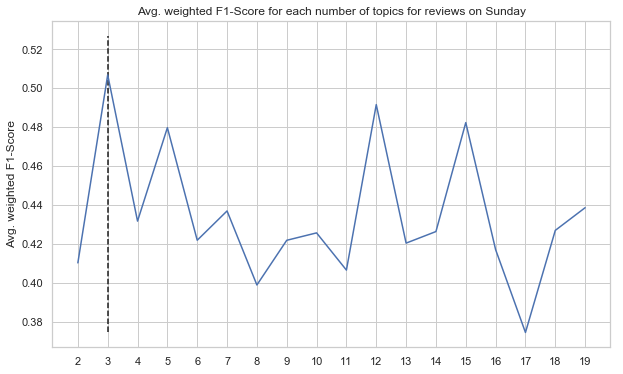

In [268]:
plt.figure(figsize=(10,6))
plt.plot(list(range(2,20, 1)), perf_sunday)
plt.title('Avg. weighted F1-Score for each number of topics for reviews on Sunday')
plt.ylabel('Avg. weighted F1-Score')
plt.xticks(range(2,20, 1))
plt.vlines(np.argmax(perf_sunday)+2,min(perf_sunday),max(perf_sunday)+0.02,linestyles='dashed')
plt.show();

From this we can see that the maximum score is achieved by using three topics. Looking at the feature importance below, topic 0 and 1 have scores quite close to eachother, which means they contribute almost equally to the classification model and can be expected to contain the most negative reviews.

In [290]:
names = np.arange(0,np.argmax(perf_sunday)+2)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), models_sunday[np.argmax(perf_sunday)+2].best_estimator_.feature_importances_),
                 names), 
             reverse=True))

Features sorted by their score:
[(0.2122, 2), (0.2067, 0), (0.2027, 1)]


#### Testing if same number of topics is reached using machine learning compared to coherence measure for our two initial datasets

In [283]:
#Create TF-IDF for subsetted datasets
tfidf_bow_good = tf_idf_trans(NLP_good.cleanReview)
tfidf_bow_bad = tf_idf_trans(NLP_bad.cleanReview)

In [284]:
%%time
#Review Score 4-5
perf_good, models_good = ML_topic(tfidf_bow_good,NLP_good.review_score,2,20)

#Review Score 1-3
perf_bad, models_bad = ML_topic(tfidf_bow_bad,NLP_bad.review_score,2,20)

Numbers of topics calculating: 2
{'n_estimators': 300}
0.6640200533212651
Numbers of topics calculating: 3
{'n_estimators': 500}
0.7041292592040584
Numbers of topics calculating: 4
{'n_estimators': 500}
0.7033991527530351
Numbers of topics calculating: 5
{'n_estimators': 300}
0.7106727541737314
Numbers of topics calculating: 6
{'n_estimators': 500}
0.7010564575268224
Numbers of topics calculating: 7
{'n_estimators': 500}
0.7074352433223313
Numbers of topics calculating: 8
{'n_estimators': 500}
0.6989612293676603
Numbers of topics calculating: 9
{'n_estimators': 500}
0.686858886260193
Numbers of topics calculating: 10
{'n_estimators': 500}
0.7112356452514497
Numbers of topics calculating: 11
{'n_estimators': 100}
0.6973215246620149
Numbers of topics calculating: 12
{'n_estimators': 500}
0.6936042376909988
Numbers of topics calculating: 13
{'n_estimators': 300}
0.6861057058314721
Numbers of topics calculating: 14
{'n_estimators': 500}
0.6994173979451269
Numbers of topics calculating: 15


##### Review Score 4-5
Optimal number of topics are 10, which is not aligned with the coherence score where the optimal number was chosen to be 3. The second highest and close in score is 5 topics which is quite close to the number of topics estimated earlier. From the feature importance we see that topic 2, 1 and 3 are most likely to have the reviews with the highest score.

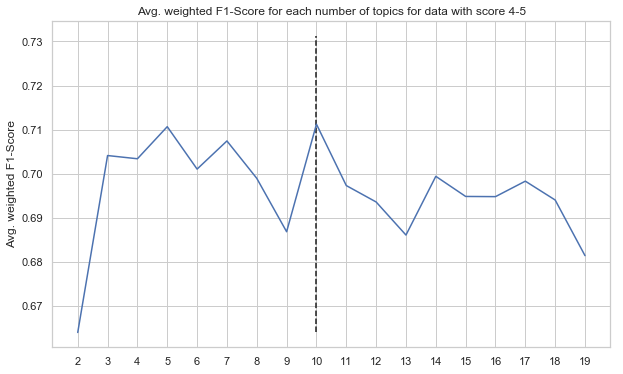

In [285]:
plt.figure(figsize=(10,6))
plt.plot(list(range(2,20, 1)), perf_good)
plt.title('Avg. weighted F1-Score for each number of topics for data with score 4-5')
plt.ylabel('Avg. weighted F1-Score')
plt.xticks(range(2,20, 1))
plt.vlines(np.argmax(perf_good)+2,min(perf_good),max(perf_good)+0.02,linestyles='dashed')
plt.show();

In [291]:
names = np.arange(0,np.argmax(perf_good)+2)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), models_good[np.argmax(perf_good)+2].best_estimator_.feature_importances_),
                 names), 
             reverse=True))

Features sorted by their score:
[(0.1146, 2), (0.0986, 3), (0.0937, 1), (0.0845, 6), (0.0843, 9), (0.0821, 4), (0.0799, 8), (0.0757, 5), (0.0722, 7), (0.0685, 0)]


##### Review Score 1-3
Optimal number of topics are 8, which not to far from the 6 topics chosen by the coherence method. From the feature importance we see that topic 4 and 7 are the most likely topics to have reviews with the highest score. Whereas topic 1, 3 and 5 are most likely to contain the most negative reviews.

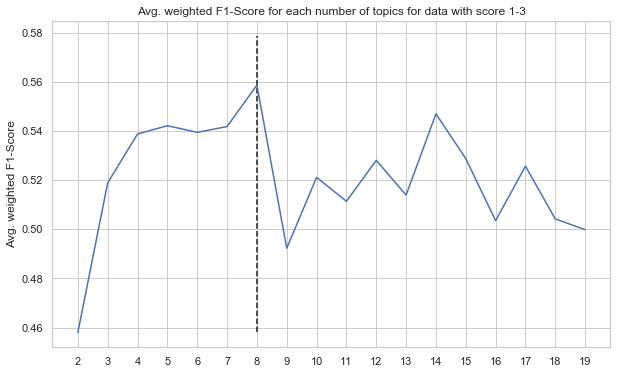

In [286]:
plt.figure(figsize=(10,6))
plt.plot(list(range(2,20, 1)), perf_bad)
plt.title('Avg. weighted F1-Score for each number of topics for data with score 1-3')
plt.ylabel('Avg. weighted F1-Score')
plt.xticks(range(2,20, 1))
plt.vlines(np.argmax(perf_bad)+2,min(perf_bad),max(perf_bad)+0.02,linestyles='dashed')
plt.show();

In [292]:
names = np.arange(0,np.argmax(perf_bad)+2)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), models_bad[np.argmax(perf_bad)+2].best_estimator_.feature_importances_),
                 names), 
             reverse=True))

Features sorted by their score:
[(0.1309, 4), (0.1166, 7), (0.0977, 6), (0.0974, 2), (0.0925, 0), (0.0897, 1), (0.0895, 3), (0.0866, 5)]


### Final remarks on Topic Modelling
*Disclaimer:* All discussion points are of course given that no portugese is known as some understanding might be lost in translatation.

It can be concluded that the topics derived in this report are hard to interpret and might be hard to use in production. A lot of the topics regarding delivery was present, which could have been expected. It would have been interesting if there had been some more distinct topics, e.g. one for delivery, one for customer-service etc., as that would have been easier in recommending how to use the results.<br>
It is however, still a relevant model and the KPI is still valuable to the company. The models have been created and if they in the future are fed more data it is likely some better results would be presented.<br>
<br>
It is possible to be critisable of the elbow method as it in the end is a visual interpretation of the development of the graph. The estimated number of topics using the classifier-model was not coherent with the estimated number using coherence scores, thus we can conclude the two methods are not completely aligned in the output. The optimal solution should however be determined by getting topics which are interpretable and makes sense in categorizing the reviews. This is not the case for this report, as all topics reached where a bit undefined and there seemed to be overlaps in the majority of them.

#### Conclusion
Topic Modelling did not present itself to be of most use for OLIST, as the topics found did not provide enough distinct categorization of the reviews. The lack of distinction between them means that it is hard to correctly direct the reviews to the right teams/persons within the organization. The valuable information gathered from this report is the the majority of reviews, both positive and negative, regards the delivery of orders and missing/defect items.


#### Further work
For further work doing topic modelling for each product category could likely provide some interesting results. There might be some useful topics to find within each product category, as we already saw specific products in some of the topics.<br>
Running the models on all of the data is another approach to extend the model, and would be preferred if more computational power was available, but given that the analysis was trained on respectively 6030 and 4159 reviews, the result is not expected to change significantly.